## 7.5 Batch Normalization
### 7.5.1 Training Deep Networks
$$
\text{BN}(\mathbf{X})=\gamma\odot\frac{\mathbf{x}-\hat{\mu}_\mathcal{B}}{\hat{\sigma}_{\mathcal{B}}}+\beta
$$

-   sample mean: $\hat{\mu}_{\mathcal{B}}=\frac1{|\mathcal{B}|}\sum_{\mathbf{x}\in\mathcal{B}}\mathbf{x}$
-   sample standard deviation: $\hat{\sigma}_{\mathcal{B}}^2=\frac1{|\mathcal{B}|}\sum_{\mathbf{x}\in\mathcal{B}}(\mathbf{x}-\hat{\mu}_{\mathcal{B}})^2+\epsilon$
-   minibatch: $\mathcal{B}$
-   scale parameter: $\gamma\sim\mathbf{x}$
-   shift parameter: $\beta\sim\mathbf{x}$

### 7.5.2 Batch Normalization Layers
#### Fully-Connected Layers
$$
\mathbf{h}=\phi(\text{BN}(\mathbf{Wx+b}))
$$
#### Convolutional Layers
$$
z=g(\text{BN}(\mathbf{Wx+b})
$$

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, init
from mxnet.gluon import nn
npx.set_np()

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not autograd.is_training():
        # 如果是预测模式，则直接使用当前的均值和方差
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 全边接层：基于特征的维度计算均值与方差
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # 二维卷积层：基于通道的维度计算均值与方差
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # 计算得到的均值与方差需要进行标准化
        X_hat = (X - mean) / np.sqrt(var + eps)
        # 使用移动平均更新均值与方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

In [3]:
class BatchNorm(nn.Block):
    def __init__(self, num_features, num_dims, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.zeros(shape)

    def forward(self, X):
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        Y, self.moving_mean, self.moving_var = batch_norm(X, 
                self.gamma.data(), self.beta.data(), self.moving_mean, self.moving_var, eps=1e-12, momentum=0.9)
        return Y

In [4]:
net=nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))

loss 0.186, train acc 0.930, test acc 0.890
18783.9 examples/sec on gpu(0)


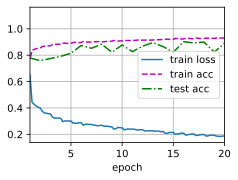

In [5]:
lr, num_epochs, batch_size = 1.0, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [6]:
net=nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

loss 0.201, train acc 0.926, test acc 0.882
46877.6 examples/sec on gpu(0)


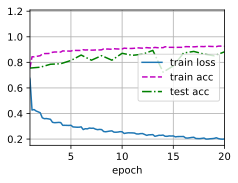

In [7]:
lr, num_epochs, batch_size = 1.0, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)